# download packages

In [1]:

!nvidia-smi

Fri Feb  3 04:35:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 450.51.05    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   36C    P0    58W / 300W |  30679MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   

In [2]:
import os
!export cuda_visible_devices=1
os.environ['CUDA_VISIBLE_DEVICES']="1"
from glob import glob

import pandas as pd


In [3]:
!nvidia-smi

Fri Feb  3 04:35:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 450.51.05    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   36C    P0    58W / 300W |  30679MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   

In [4]:
import warnings # tf needs to learn to stfu
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [5]:
!pip install plotly

# Import the libraries

In [6]:
import numpy as np
import pandas as pd

import io
import os
import tensorflow as tf

from PIL import Image
from glob import glob
import itertools

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, Dropout, Dense, MaxPool2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from IPython.display import display

import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from time import time
import numpy as np

#To see the value of multiple statements at once.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# prepare train test splits

In [7]:
def prepare_for_train_test(X, Y):
    # Splitting into train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
    
    # Prepare data for training and testing the model
    train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 10,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  fill_mode = 'nearest')
    
    train_datagen.fit(X_train)
    test_datagen = ImageDataGenerator(rescale = 1./255)
    test_datagen.fit(X_test)
    return X_train, X_test, Y_train, Y_test

# Prepare model

In [53]:

def squeezenet(input_shape=(224,224,3), n_classes=7):
  
  def fire(x, fs, fe):
    s = Conv2D(fs, 1, activation='relu')(x)
    e1 = Conv2D(fe, 1, activation='relu')(s)
    e3 = Conv2D(fe, 3, padding='same', activation='relu')(s)
    output = Concatenate()([e1, e3])
    return output
  
  
  input = Input(input_shape)
  
  x = Conv2D(96, 7, strides=2, padding='same', activation='relu')(input)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  x = fire(x, 16, 64)
  x = fire(x, 16, 64)
  x = fire(x, 32, 128)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  x = fire(x, 32, 128)


  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  #x = fire(x, 64, 256)
  x = Conv2D(n_classes, 1)(x)
  x = GlobalAvgPool2D()(x)
  
  output = Activation('softmax')(x)
  
  model = Model(input, output)
  return model
def create_model():
    return squeezenet()

# prepare the training plan

In [9]:
def train_model(model, X_train, Y_train, EPOCHS=25):
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, 
                           mode='auto')
                               #, restore_best_weights=True)
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, 
                              verbose=1, mode='auto')
    
    history = model.fit(X_train,
                        Y_train,
                        validation_split=0.2,
                        batch_size = 64,
                        epochs = EPOCHS,
                        callbacks = [reduce_lr, early_stop])
    return history

# test the model

In [10]:
def test_model(model, X_test, Y_test):
    model_acc = model.evaluate(X_test, Y_test, verbose=0)[1]
    print("Test Accuracy: {:.3f}%".format(model_acc * 100))
    y_true = np.array(Y_test)
    y_pred = model.predict(X_test)
    y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
    clr = classification_report(y_true, y_pred, target_names=label_mapping.values())
    print(clr)
    
    sample_data = X_test[:15]
    plt.figure(figsize=(22, 12))
    for i in range(15):
        plt.subplot(3, 5, i + 1)
        plt.imshow(sample_data[i])
        plt.title(label_mapping[y_true[i][0]] + '|' + label_mapping[y_pred[i]])
        plt.axis("off")
    plt.show()
    return y_true, y_pred

# training curves plot

# multi class confusion matrix

In [11]:
def create_confusion_matrix(model, x_test_normalized, y_test, cm_plot_labels, name, y_true,y_pred):
    #Get the true and predicted labels
    y_predict_classes, y_true_classes = y_pred,y_true

    #Compute the confusion matrix
    confusion_matrix_computed = confusion_matrix(y_true_classes, y_predict_classes)

    #Plot the confusion matrix
    plot_confusion_matrix(confusion_matrix_computed, cm_plot_labels, name) 

In [12]:
def plot_confusion_matrix(cm, classes,
                          name,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(name)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
#     b, t = plt.ylim()
#     b += 0.5
#     t -= 0.5
#     plt.ylim(b, t)
    
    plt.tight_layout()
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    fig = plt
    fig.savefig('C:\\Users\\Marwan Gamal\\Downloads\\Skin Cancer\\Photo\\' + name + '_confusion_matrix.png', dpi=300)

# read the data

In [13]:
base_skin_dir = os.path.join('..', '')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('/home/talapallysk/Ham10000/', '*', '*.jpg'))}
#print(imageid_path_dict)
#imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
   #                  for x in glob(os.path.join(base_skin_dir,"skin-cancer-mnist-ham10000/", '*', '*.jpg'))}
lesion_type_dict = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)'
}
label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}
reverse_label_mapping = dict((value, key) for key, value in label_mapping.items())

In [14]:

data = pd.read_csv('/home/talapallysk/Ham10000/HAM10000_metadata.csv') #pd.read_csv(os.path.join(base_skin_dir,"Ham1/",'HAM10000_metadata'))
print(data.info)

# Creating New Columns for better readability

# data['path'] = data['image_id'].map(imageid_path_dict.get)
# data['cell_type'] = data['dx'].map(lesion_type_dict.get) 
# data['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes


<bound method DataFrame.info of          lesion_id      image_id     dx dx_type   age     sex localization  \
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp   
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp   
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp   
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp   
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear   
...            ...           ...    ...     ...   ...     ...          ...   
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen   
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen   
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen   
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face   
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back   

            dataset  
0      vi

In [75]:
# Now lets see the sample of tile_df to look on newly made columns
data.head()

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,cell_type,path,image_pixel,label
0,5007,HAM_0006322,ISIC_0030309,nv,follow_up,55,male,foot,vidir_molemax,Melanocytic nevi (nv),/home/talapallysk/Ham10000/HAM10000_images_par...,"[[[237, 160, 172], [237, 159, 172], [238, 159,...",0
1,4478,HAM_0003084,ISIC_0026191,nv,follow_up,45,female,upper extremity,vidir_molemax,Melanocytic nevi (nv),/home/talapallysk/Ham10000/HAM10000_images_par...,"[[[215, 106, 131], [212, 99, 129], [213, 98, 1...",0
2,4477,HAM_0002093,ISIC_0027032,nv,follow_up,45,female,back,vidir_molemax,Melanocytic nevi (nv),/home/talapallysk/Ham10000/HAM10000_images_par...,"[[[230, 126, 145], [230, 127, 147], [232, 129,...",0
3,4476,HAM_0003701,ISIC_0027191,nv,follow_up,45,female,lower extremity,vidir_molemax,Melanocytic nevi (nv),/home/talapallysk/Ham10000/HAM10000_images_par...,"[[[214, 121, 156], [213, 119, 155], [215, 121,...",0
4,4475,HAM_0003806,ISIC_0028667,nv,follow_up,45,female,lower extremity,vidir_molemax,Melanocytic nevi (nv),/home/talapallysk/Ham10000/HAM10000_images_par...,"[[[229, 136, 158], [231, 139, 162], [237, 144,...",0


In [16]:
data.describe(exclude=[np.number])

,lesion_id,image_id,dx,dx_type,sex,localization,dataset
count,10015,10015,10015,10015,10015,10015,10015
unique,7470,10015,7,4,3,15,4
top,HAM_0003789,ISIC_0027419,nv,histo,male,back,vidir_molemax
freq,6,1,6705,5340,5406,2192,3954


In [17]:
data.isnull().any().sum()

1

# Imputing the Null values and preparing the data

In [18]:
# Handling null values
data['age'].fillna(value=int(data['age'].mean()), inplace=True)
# Converting dtype of age to int32
data['age'] = data['age'].astype('int32')

In [19]:
# Adding cell_type and image_path columns

#skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)
#Use the path to read images.
#skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

data['cell_type'] = data['dx'].map(lesion_type_dict.get)
#print(imageid_path_dict)
#print(imageid_path_dict)
data['path'] = data['image_id'].map(imageid_path_dict.get)

In [20]:
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,cell_type,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80,male,scalp,vidir_modern,Benign keratosis-like lesions (bkl),/home/talapallysk/Ham10000/HAM10000_images_par...
1,HAM_0000118,ISIC_0025030,bkl,histo,80,male,scalp,vidir_modern,Benign keratosis-like lesions (bkl),/home/talapallysk/Ham10000/HAM10000_images_par...
2,HAM_0002730,ISIC_0026769,bkl,histo,80,male,scalp,vidir_modern,Benign keratosis-like lesions (bkl),/home/talapallysk/Ham10000/HAM10000_images_par...
3,HAM_0002730,ISIC_0025661,bkl,histo,80,male,scalp,vidir_modern,Benign keratosis-like lesions (bkl),/home/talapallysk/Ham10000/HAM10000_images_par...
4,HAM_0001466,ISIC_0031633,bkl,histo,75,male,ear,vidir_modern,Benign keratosis-like lesions (bkl),/home/talapallysk/Ham10000/HAM10000_images_par...


In [21]:
# Adding image pixels
data['image_pixel'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((224,224))))

In [22]:
data.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,cell_type,path,image_pixel
0,HAM_0000118,ISIC_0027419,bkl,histo,80,male,scalp,vidir_modern,Benign keratosis-like lesions (bkl),/home/talapallysk/Ham10000/HAM10000_images_par...,"[[[187, 150, 192], [190, 154, 195], [192, 156,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80,male,scalp,vidir_modern,Benign keratosis-like lesions (bkl),/home/talapallysk/Ham10000/HAM10000_images_par...,"[[[24, 13, 22], [25, 13, 23], [24, 14, 23], [2..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80,male,scalp,vidir_modern,Benign keratosis-like lesions (bkl),/home/talapallysk/Ham10000/HAM10000_images_par...,"[[[186, 127, 135], [188, 129, 137], [191, 135,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80,male,scalp,vidir_modern,Benign keratosis-like lesions (bkl),/home/talapallysk/Ham10000/HAM10000_images_par...,"[[[23, 11, 15], [24, 11, 18], [24, 10, 19], [2..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75,male,ear,vidir_modern,Benign keratosis-like lesions (bkl),/home/talapallysk/Ham10000/HAM10000_images_par...,"[[[125, 83, 105], [132, 89, 112], [138, 93, 11..."


In [23]:
# Displaying 2 images for each label
'''
sample_data = data.groupby('dx').apply(lambda df: df.iloc[:2, [9, 7]])
print(sample_data)
plt.figure(figsize=(22, 32))
for i in range(14):
    plt.subplot(7, 5, i + 1)
    plt.imshow(np.squeeze(sample_data['image_pixel'][i]))
    img_label = sample_data['cell_type'][i]
    plt.title(img_label)
    plt.axis("off")
plt.show();
'''

'\nsample_data = data.groupby(\'dx\').apply(lambda df: df.iloc[:2, [9, 7]])\nprint(sample_data)\nplt.figure(figsize=(22, 32))\nfor i in range(14):\n    plt.subplot(7, 5, i + 1)\n    plt.imshow(np.squeeze(sample_data[\'image_pixel\'][i]))\n    img_label = sample_data[\'cell_type\'][i]\n    plt.title(img_label)\n    plt.axis("off")\nplt.show();\n'

In [24]:
data['label'] = data['dx'].map(reverse_label_mapping.get)

data = data.sort_values('label')
data = data.reset_index()

In [25]:
counter = 0
frames = [data]
for i in [4,4,11,17,45,52]:
    counter+=1
    index = data[data['label'] == counter].index.values
    df_index = data.iloc[int(min(index)):int(max(index)+1)]
    df_index = df_index.append([df_index]*i, ignore_index = True)
    frames.append(df_index)
    

In [26]:
len(frames)

7

In [27]:
final_data = pd.concat(frames)

In [28]:
print(data.shape)
print(final_data.shape)

(10015, 13)
(45756, 13)


In [29]:
# ORIGINAL DATA
# Converting image pixel columnm into required format
X_orig = data['image_pixel'].to_numpy()
X_orig = np.stack(X_orig, axis=0)
Y_orig = np.array(data.iloc[:, -1:])
print(X_orig.shape)
print(Y_orig.shape)

(10015, 224, 224, 3)
(10015, 1)


In [30]:
# AUGMENTED DATA
# Converting image pixel columnm into required format
X_aug = final_data['image_pixel'].to_numpy()
X_aug = np.stack(X_aug, axis=0)
Y_aug = np.array(final_data.iloc[:, -1:])
print(X_aug.shape)
print(Y_aug.shape)

(45756, 224, 224, 3)
(45756, 1)


In [31]:
# For Original Dataset
X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = prepare_for_train_test(X_orig, Y_orig)
print(X_train_orig.shape)

(8012, 224, 224, 3)


In [54]:
model =create_model()
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adamax', metrics = ['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_36 (Conv2D)             (None, 112, 112, 96  14208       ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_9 (MaxPooling2D)  (None, 56, 56, 96)  0           ['conv2d_36[0][0]']              
                                                                                            

In [70]:
model.summary()
X_train_aug, X_test_aug, Y_train_aug, Y_test_aug = prepare_for_train_test(X_aug, Y_aug)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_36 (Conv2D)             (None, 112, 112, 96  14208       ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_9 (MaxPooling2D)  (None, 56, 56, 96)  0           ['conv2d_36[0][0]']              
                                                                                            

In [55]:
model2_history = train_model(model, X_train_aug, Y_train_aug, 300)

Epoch 1/300


2023-02-03 05:05:14.049528: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla V100-SXM2-32GB" frequency: 1530 num_cores: 80 environment { key: "architecture" value: "7.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 98304 memory_size: 28930998272 bandwidth: 898048000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


458/458 [==============================] - ETA: 0s - loss: 1.7261 - accuracy: 0.3123

2023-02-03 05:05:33.847009: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla V100-SXM2-32GB" frequency: 1530 num_cores: 80 environment { key: "architecture" value: "7.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 98304 memory_size: 28930998272 bandwidth: 898048000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


458/458 [==============================] - 23s 47ms/step - loss: 1.7261 - accuracy: 0.3123 - val_loss: 1.4898 - val_accuracy: 0.4401 - lr: 0.0010
Epoch 2/300
458/458 [==============================] - 19s 42ms/step - loss: 1.4024 - accuracy: 0.4731 - val_loss: 1.2884 - val_accuracy: 0.5196 - lr: 0.0010
Epoch 3/300
458/458 [==============================] - 20s 44ms/step - loss: 1.2652 - accuracy: 0.5252 - val_loss: 1.1725 - val_accuracy: 0.5466 - lr: 0.0010
Epoch 4/300
458/458 [==============================] - 20s 44ms/step - loss: 1.1681 - accuracy: 0.5604 - val_loss: 1.0767 - val_accuracy: 0.6029 - lr: 0.0010
Epoch 5/300
458/458 [==============================] - 22s 47ms/step - loss: 1.0957 - accuracy: 0.5887 - val_loss: 0.9856 - val_accuracy: 0.6245 - lr: 0.0010
Epoch 6/300
458/458 [==============================] - 22s 48ms/step - loss: 1.0269 - accuracy: 0.6123 - val_loss: 0.9625 - val_accuracy: 0.6231 - lr: 0.0010
Epoch 7/300
458/458 [==============================] - 23s 49ms/

In [56]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_36 (Conv2D)             (None, 112, 112, 96  14208       ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_9 (MaxPooling2D)  (None, 56, 56, 96)  0           ['conv2d_36[0][0]']              
                                                                                            

# save model

In [71]:
model.save('Skin_Cancer.h5')
print(tf.__version__)

2.8.0


In [37]:
from IPython.display import FileLink
FileLink('Skin_Cancer.h5')

/home/talapallysk/Final models\/Untitled Folder/Skin_Cancer.h5

# save model weights

In [38]:
model.save_weights("Skin_Cancer.hdf5")

In [39]:
from IPython.display import FileLink
FileLink('Skin_Cancer.hdf5')

/home/talapallysk/Final models\/Untitled Folder/Skin_Cancer.hdf5

5.10.0


Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

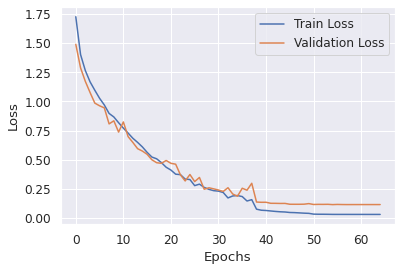

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

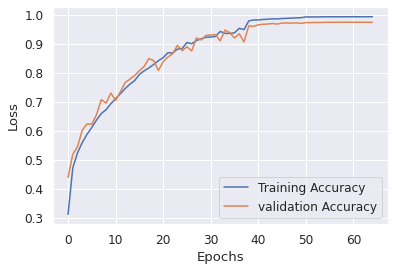

In [72]:
!pip install  kaleido
import plotly
print(plotly.__version__)
import kaleido
import numpy as np
import matplotlib.pyplot as plt
 
x = model2_history.history['loss']
y = np.array([i for i in range(65) ])
 
# Plotting the Graph
plt.plot(y, x,label="Train Loss")
x = model2_history.history['val_loss']
y = np.array([i for i in range(65) ])

plt.plot(y, x,label="Validation Loss")
plt.legend()
#fig.savefig(image_name, format=image_format, dpi=1200)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig("loss", format='svg', dpi=1200)
plt.savefig("loss.png",dpi=1200)
plt.show()

x = model2_history.history['accuracy']
y = np.array([i for i in range(65) ])
 
# Plotting the Graph
plt.plot(y, x,label="Training Accuracy")
x = model2_history.history['val_accuracy']
y = np.array([i for i in range(65) ])

plt.plot(y, x,label="validation Accuracy")
plt.legend()
#fig.savefig(image_name, format=image_format, dpi=1200)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig("ac", format='svg', dpi=1200)
plt.savefig("loss.png",dpi=1200)
plt.show()


def plot_model_training_curve(history):
    
    fig = make_subplots(rows=1, cols=2, subplot_titles=['Model Accuracy', 'Model Loss'])
    fig.add_trace(
        go.Scatter(
            y=history.history['accuracy'], 
            name='train_acc'), 
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_accuracy'], 
            name='val_acc'), 
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['loss'], 
            name='train_loss'), 
        row=1, col=2)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_loss'], 
            name='val_loss'), 
        row=1, col=2)
    fig.show()
    
plot_model_training_curve(model2_history)

plot_model_training_curve(model2_history)

In [ ]:
y_true, y_pred=test_model(model, X_test_orig, Y_test_orig)

In [ ]:
data.head()
data.iloc[2]

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
y_pred  = model.predict(X_test_orig).round()

In [ ]:
'''單張圖片的預測1'''
one_picture_predict_data = data.iloc[2]
print(one_picture_predict_data)
print(one_picture_predict_data.dx)
#print(one_picture_predict_data.image_pixel)
y_value = reverse_label_mapping.get(one_picture_predict_data.dx)
print(y_value)


one_picture_predict_data.image_pixel.shape
new_one = one_picture_predict_data.image_pixel.reshape((1,224,224,3))
model.predict(new_one)

In [ ]:
'''單張圖片的預測2'''
print(data.iloc[2].path)
im = np.asarray(Image.open(data.iloc[2].path))
im.shape
im = im.reshape((1,450,600,3))
im.shape
new_one = one_picture_predict_data.image_pixel.reshape((1,224,224,3))
model.predict(new_one)

Test Accuracy: 97.039%


2023-02-03 05:32:22.568568: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla V100-SXM2-32GB" frequency: 1530 num_cores: 80 environment { key: "architecture" value: "7.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 98304 memory_size: 28930998272 bandwidth: 898048000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


              precision    recall  f1-score   support

          nv       0.98      0.83      0.89      1385
         mel       0.92      0.98      0.95      1328
         bkl       0.93      0.99      0.96      1294
         bcc       0.98      1.00      0.99      1325
       akiec       1.00      1.00      1.00      1270
        vasc       1.00      1.00      1.00      1293
          df       1.00      1.00      1.00      1257

    accuracy                           0.97      9152
   macro avg       0.97      0.97      0.97      9152
weighted avg       0.97      0.97      0.97      9152



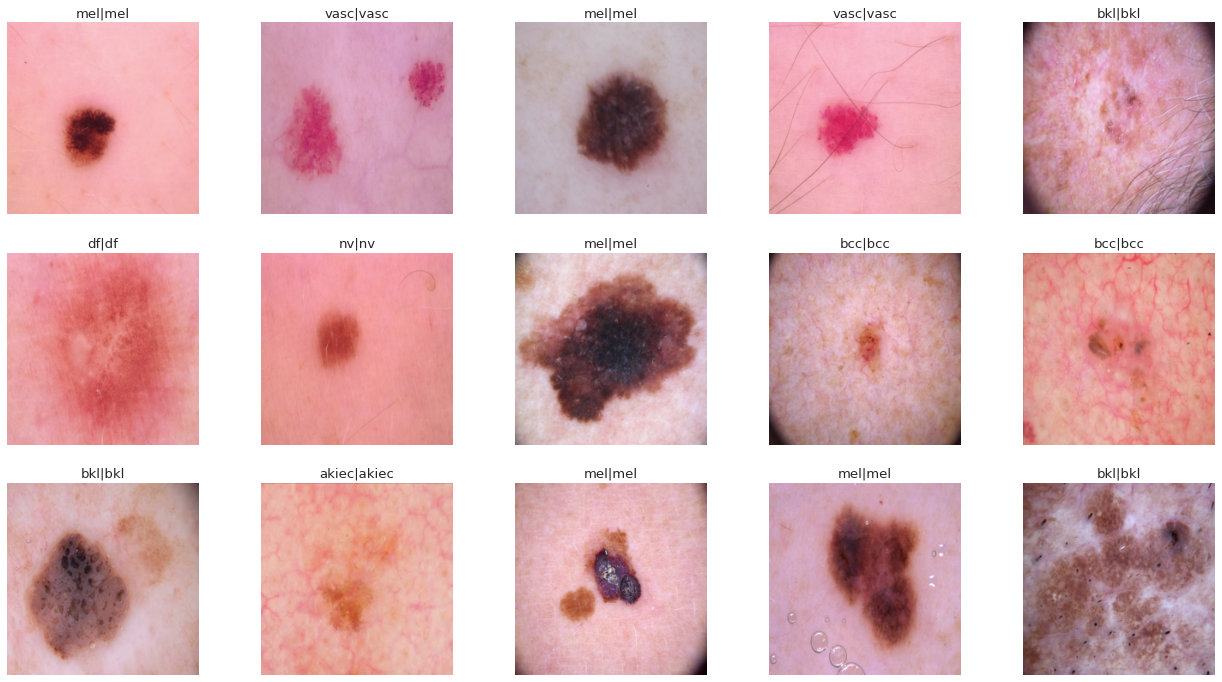

In [59]:
y_true_aug, y_pred_aug = test_model(model, X_test_aug,Y_test_aug)

{0: 'nv', 1: 'mel', 2: 'bkl', 3: 'bcc', 4: 'akiec', 5: 'vasc', 6: 'df'}
0    6705
1    1113
2    1099
3     514
4     327
5     142
6     115
Name: label, dtype: int64


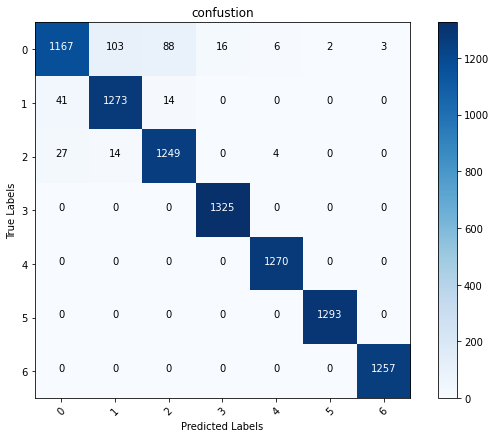

In [46]:
def create_confusion_matrix(model, x_test_normalized, y_test, cm_plot_labels, name, y_true,y_pred):
    #Get the true and predicted labels
    y_predict_classes, y_true_classes = y_pred,y_true

    #Compute the confusion matrix
    confusion_matrix_computed = confusion_matrix(y_true_classes, y_predict_classes)

    #Plot the confusion matrix
    plot_confusion_matrix(confusion_matrix_computed, cm_plot_labels, name) 
def plot_confusion_matrix(cm, classes,
                          name,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    print(classes)
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(name)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
#     b, t = plt.ylim()
#     b += 0.5
#     t -= 0.5
#     plt.ylim(b, t)
    
    plt.tight_layout()
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    fig = plt
    fig.savefig('C:\\Users\\Marwan Gamal\\Downloads\\Skin Cancer\\Photo\\' + name + '_confusion_matrix.png', dpi=300)
#create_confusion_matrix(model, X_test_orig, Y_test_orig, label_mapping, 'confustion', y_true, y_pred)
create_confusion_matrix(model, X_test_aug, Y_test_aug, label_mapping, 'confustion', y_true_aug, y_pred_aug)
#print(data.info)
print(data['label'].value_counts())

In [61]:
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix,roc_curve
print("Precision: "+ str(precision_score(y_true_aug, y_pred_aug, average='weighted')))
print("Recall: "+ str(recall_score(y_true_aug, y_pred_aug, average='weighted')))
print("Accuracy: " + str(accuracy_score(y_true_aug, y_pred_aug)))
z=model.predict(X_test_aug)
print("weighted Roc score: " + str(roc_auc_score(Y_test_aug,z,multi_class='ovr',average='weighted')))

Precision: 0.9713533969912396
Recall: 0.970388986013986
Accuracy: 0.970388986013986


NameError: name 'roc_auc_score' is not defined

In [62]:
print("Precision: "+ str(precision_score(y_true_aug, y_pred_aug, average='macro')))
print("Recall: "+ str(recall_score(y_true_aug, y_pred_aug, average='macro')))
print("Accuracy: " + str(accuracy_score(y_true_aug, y_pred_aug)))
z=model.predict(X_test_aug)
print("Macro Roc score: " + str(roc_auc_score(Y_test_aug,z,multi_class='ovr',average='macro')))

Precision: 0.9716238987487278
Recall: 0.9718791125260944
Accuracy: 0.970388986013986


NameError: name 'roc_auc_score' is not defined

In [63]:
print("Precision: "+ str(precision_score(y_true_aug, y_pred_aug, average='micro')))
print("Recall: "+ str(recall_score(y_true_aug, y_pred_aug, average='micro')))
print("Accuracy: " + str(accuracy_score(y_true_aug, y_pred_aug)))
z=model.predict(X_test_aug)



Precision: 0.970388986013986
Recall: 0.970388986013986
Accuracy: 0.970388986013986


{0: 'nv', 1: 'mel', 2: 'bkl', 3: 'bcc', 4: 'akiec', 5: 'vasc', 6: 'df'}


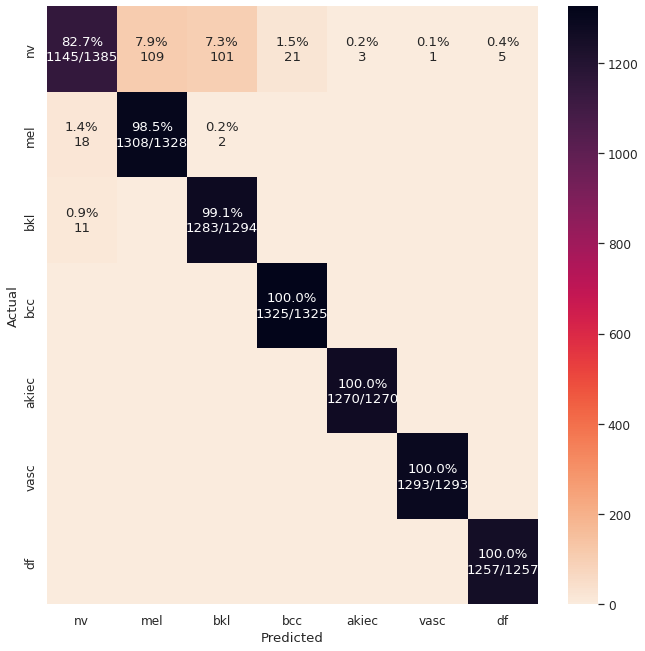

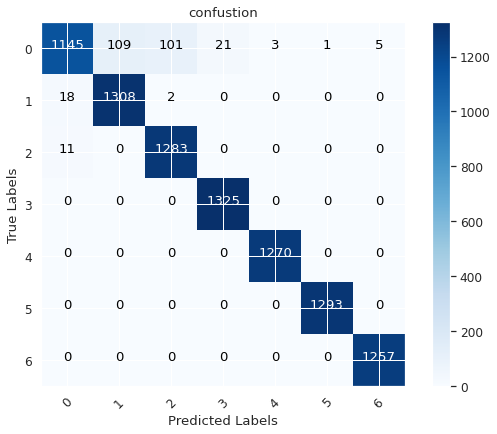

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def cm_analysis(y_true, y_pred, filename, labels, ymap=None, figsize=(11,11)):
    sns.set(font_scale=1.1)
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[int(yi)] for yi in y_pred]
        y_true = [ymap[int(yi)] for yi in y_true]
        labels = [ymap[int(yi)] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax,cmap='rocket_r')
    plt.savefig(filename)
cm_analysis(y_true_aug, y_pred_aug,'snet',list(label_mapping.keys()),label_mapping)

create_confusion_matrix(model, X_test_aug, Y_test_aug, label_mapping, 'confustion', y_true_aug, y_pred_aug)

#### 